<a href="https://colab.research.google.com/github/vandanarekha/TCS-iON/blob/main/VANDANA_IRAGAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from __future__ import division
import numpy as np
import os
import glob
from random import *
from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
# %matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, RMSprop
from google.colab import drive

In [17]:
drive.mount('/content/gdrive')
d = {}
from subprocess import check_output
with open('/content/gdrive/My Drive/TCS iON/formss.txt') as f:
  for line in f:
    key = line.split(' ')[0]
    writer = line.split(' ')[1]
    d[key] = writer
print(len(d.keys()))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
1539


In [19]:
tmp = []
target_list = []
path_to_files = os.path.join('gdrive/My Drive/TCS iON/data_subset','*')
for filename in sorted(glob.glob(path_to_files)):    
    tmp.append(filename)
    image_name = filename.split('/')[-1]
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    print(parts)
    form = parts[0] + '-' + parts[1]
    
    for key in d:
        if key == form:
            target_list.append(str(d[form]))

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
print(img_files)
print(img_targets)

['j06', '051', 's00', '05']
['j06', '051', 's01', '01']
['j06', '051', 's02', '00']
['j06', '051', 's02', '02']
['j06', '051', 's02', '03']
['j06', '051', 's03', '00']
['j06', '056', 's00', '02']
['j06', '056', 's01', '00']
['j06', '056', 's01', '01']
['j06', '056', 's01', '02']
['j06', '056', 's02', '00']
['j06', '056', 's02', '01']
['m06', '019', 's00', '00']
['m06', '019', 's00', '01']
['m06', '019', 's01', '00']
['m06', '019', 's02', '00']
['m06', '019', 's03', '00']
['m06', '019', 's04', '00']
['m06', '019', 's05', '00']
['m06', '019', 's06', '00']
['m06', '019', 's07', '01']
['m06', '019', 's08', '00']
['m06', '019', 's08', '01']
['m06', '019', 's09', '00']
['m06', '019', 's10', '00']
['m06', '019', 's10', '01']
['m06', '031', 's00', '00']
['m06', '031', 's01', '00']
['m06', '031', 's03', '00']
['m06', '031', 's04', '00']
['m06', '031', 's05', '00']
['m06', '031', 's06', '00']
['m06', '031', 's06', '01']
['m06', '031', 's08', '00']
['m06', '031', 's09', '01']
['m06', '042', 's00'

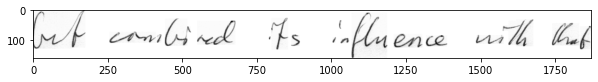

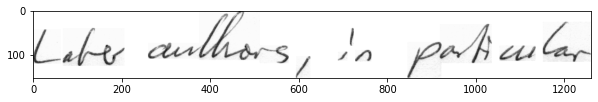

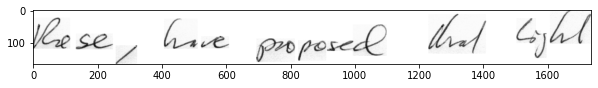

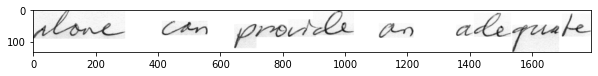

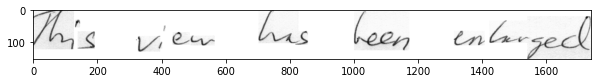

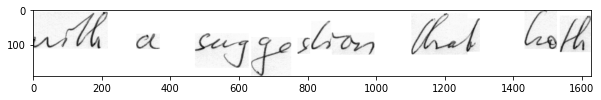

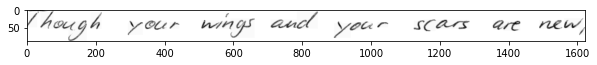

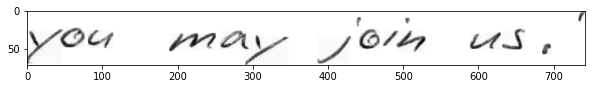

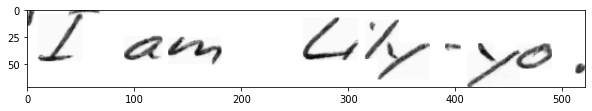

In [20]:
# Visualizing the data
for filename in img_files[6:15]:
    img=mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')


In [21]:
# Label Encode writer names for one hot encoding later
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)

print(img_files[6:15], img_targets[6:15], encoded_Y[6:15])

['gdrive/My Drive/TCS iON/data_subset/j06-056-s00-02.png'
 'gdrive/My Drive/TCS iON/data_subset/j06-056-s01-00.png'
 'gdrive/My Drive/TCS iON/data_subset/j06-056-s01-01.png'
 'gdrive/My Drive/TCS iON/data_subset/j06-056-s01-02.png'
 'gdrive/My Drive/TCS iON/data_subset/j06-056-s02-00.png'
 'gdrive/My Drive/TCS iON/data_subset/j06-056-s02-01.png'
 'gdrive/My Drive/TCS iON/data_subset/m06-019-s00-00.png'
 'gdrive/My Drive/TCS iON/data_subset/m06-019-s00-01.png'
 'gdrive/My Drive/TCS iON/data_subset/m06-019-s01-00.png'] ['415' '415' '415' '415' '415' '415' '551' '551' '551'] [1 1 1 1 1 1 2 2 2]


In [22]:
#split into test train and validation in ratio 4:1:1

from sklearn.model_selection import train_test_split
train_files, rem_files, train_targets, rem_targets = train_test_split(
        img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)

validation_files, test_files, validation_targets, test_targets = train_test_split(
        rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(587,) (151,) (152,)
(587,) (151,) (152,)


In [24]:
batch_size = 16
num_classes = 50


def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
 
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]

                
                height_fac = 113 / cur_height

                new_width = int(cur_width * height_fac)
                size = new_width, 113

                imresize = im.resize((size), Image.ANTIALIAS)  
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                

                avail_x_points = list(range(0, now_width - 113 ))

            
                pick_num = int(len(avail_x_points)*factor)

              
                random_startx = sample(avail_x_points,  pick_num)

                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)

            
            X_train = np.array(images)
            y_train = np.array(targets)

           
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
           
            X_train = X_train.astype('float32')
            X_train /= 255

         
            y_train = to_categorical(y_train, num_classes)

            yield shuffle(X_train, y_train)

In [26]:
# Generate data for training and validation
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)

In [27]:
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize_images(image,[56,56])


row, col, ch = 113, 113, 1

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))


#model.add(Lambda(resize_image)) 
#model.add(Lambda(lambda x: resize_image))


model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Convolution2D(filters= 128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3')) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, name='dense1'))  

model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))  
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 115, 115, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 58, 58, 32)        832       
_________________________________________________________________
activation (Activation)      (None, 58, 58, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 29, 29, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 29, 29, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 29, 29, 64)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 14, 14, 64)        0

In [30]:
#Saving the model and weights into GDrive

from keras.models import model_from_json   
# serialize model to JSON
model_json = model.to_json()
with open("gdrive/My Drive/Models/HTR_Model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("gdrive/My Drive/Models/HTR_model_weights.hdf5")
print("Saved model to GDrive")

Saved model to GDrive


In [31]:
#Loading json and weights to recover model
import tensorflow as tf
json_file = open("gdrive/My Drive/Models/HTR_Model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
l_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
l_model.load_weights("gdrive/My Drive/Models/HTR_model_weights.hdf5")
print("Loaded model from Gdrive")

Loaded model from Gdrive


In [32]:
model.save("gdrive/My Drive/Models/HTR_model.hdf5")
print("Saved Keras Model")

Saved Keras Model


In [33]:
#from keras.models import load_model
# load model
from tensorflow import keras
loaded_model = keras.models.load_model("gdrive/My Drive/Models/HTR_model.hdf5", custom_objects=None, compile=True, options=None)
print("Loaded the Keras Model")

Loaded the Keras Model


In [34]:
print(loaded_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 115, 115, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 58, 58, 32)        832       
_________________________________________________________________
activation (Activation)      (None, 58, 58, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 29, 29, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 29, 29, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 29, 29, 64)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 14, 14, 64)        0

In [37]:
images = []
for filename in test_files[:50]:
    im = Image.open(filename)
    cur_width = im.size[0]
    cur_height = im.size[1]

   
    height_fac = 113 / cur_height

    new_width = int(cur_width * height_fac)
    size = new_width, 113

    imresize = im.resize((size), Image.ANTIALIAS)  
    now_width = imresize.size[0]
    now_height = imresize.size[1]


    avail_x_points = list(range(0, now_width - 113 ))

    
    factor = 0.1
    pick_num = int(len(avail_x_points)*factor)
    
    random_startx = sample(avail_x_points,  pick_num)

    for start in random_startx:
        imcrop = imresize.crop((start, 0, start+113, 113))
        images.append(np.asarray(imcrop))
        
    X_test = np.array(images)
    
    X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
   
    X_test = X_test.astype('float32')
    X_test /= 255
    shuffle(X_test)

print(X_test.shape)

(5582, 113, 113, 1)


In [38]:
predictions = loaded_model.predict(X_test, verbose =1)

print(predictions.shape)
predicted_writer = []
for pred in predictions:
    predicted_writer.append(np.argmax(pred))
print(len(predicted_writer))

175/175 [==============================] - 12s 67ms/step
(5582, 50)
5582


In [39]:
writer_number = 18
total_images =10
counter = 0
for i in range(len(predicted_writer)//10):
    if predicted_writer[i] == writer_number:
        image = X_test[i].squeeze()
        plt.figure(figsize=(2,2))
        plt.imshow(image, cmap ='gray')

In [40]:
writer_number = 18
total_images =10
counter = 0
print("Vandana Iragar")
for i in range(len(predicted_writer)//10):
    if predicted_writer[i] == writer_number:
        image = X_test[i].squeeze()
        plt.figure(figsize=(2,2))
        plt.imshow(image, cmap ='gray')
        plt.show()

Vandana Iragar


In [45]:
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()